Known Image Size:  (4032, 3024) <class 'tuple'> 4032


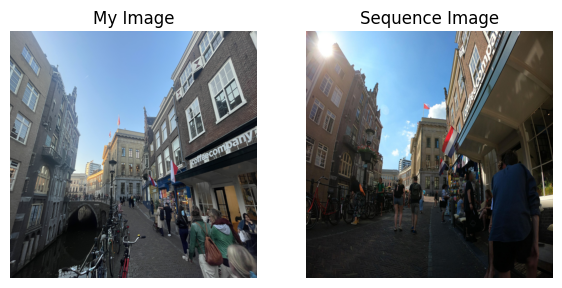

In [6]:
# import matplotlib.pyplot as plt
# from PIL import Image
# known_image_path = '/home/bjangley/VPR/VPRMethods/utrecht_experiment1_images/IMG_1539.JPG'
# known_image2_path = '/home/bjangley/VPR/VPRMethods/utrecht_experiment1_images/IMG_1540.JPG'
# sequence_image_path = '/home/bjangley/VPR/mapillary_utils/mapillary_sequence_2/799338198457726.jpg'

# # Load the images
# known_image = Image.open(known_image_path)
# known_image_size = known_image.size  #original size of image
# known_image = known_image.resize((512, 512)) #resizing the image
# sequence_image = Image.open(sequence_image_path).resize((512, 512))

# print("Known Image Size: ", known_image_size, type(known_image_size), known_image_size[0], known_image_size[1])

# # Display the images side by side
# plt.figure(figsize=(7, 4))

# # Show the first image
# plt.subplot(1, 2, 1)
# plt.imshow(known_image)
# plt.axis('off')
# plt.title("My Image")

# # Show the second image
# plt.subplot(1, 2, 2)
# plt.imshow(sequence_image)
# plt.axis('off')
# plt.title("Sequence Image")

# plt.show()

In [3]:
# Convert and save the images as PNG
# my_image_png_path = '/home/bjangley/VPR/mast3r/utrecht/IMG_1539_converted.png'
# sequence_image_png_path = '/home/bjangley/VPR/mast3r/utrecht/799338198457726_converted.png'

# known_image.save(my_image_png_path, format='PNG')
# sequence_image.save(sequence_image_png_path, format='PNG')

(512, 512)
(512, 512)


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/utrecht/IMG_1539_converted.png with resolution 512x512 --> 512x384
 - adding /home/bjangley/VPR/mast3r/utrecht/799338198457726_converted.png with resolution 512x512 --> 512x384
 (Found 2 images)


/home/bjangley/VPR/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/bjangley/VPR/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/bjangley/VPR/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


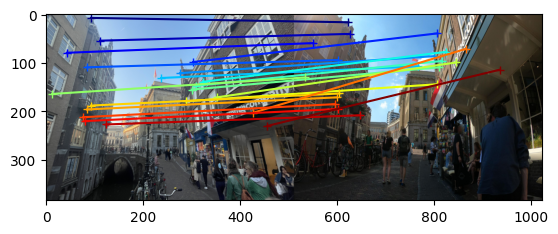

Predicted Transform:
 [[ 0.77368639  0.21692773 -0.5952745   5.84364295]
 [-0.13406475  0.97433639  0.18081827 -0.6085284 ]
 [ 0.6192221  -0.06009131  0.78291316 -0.87626026]
 [ 0.          0.          0.          1.        ]]


In [46]:
known_image_path = '/home/bjangley/VPR/mast3r/utrecht/IMG_1539_converted.png'
unknown_image_path = '/home/bjangley/VPR/mast3r/utrecht/799338198457726_converted.png'
known_image_size = [4032, 3024]
master_size = [384, 512]

"""Getting mast3r output"""


from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

#imports for visualizing matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl


#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

device = 'cuda:6'
schedule = 'cosine'
lr = 0.01
niter = 300
boarder = 3


def getMasterOutout(known_image, unknown_image, visualizeMatches=False): 
    #inputs known image and unknown image paths to return mast3r output

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    ##load model and run inference
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    images = load_images([known_image, unknown_image], size=512)
    #print(images[0]['true_shape'])
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']

    desc1 = pred1['desc'].squeeze(0).detach()
    desc2 = pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                    device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= boarder) & (matches_im0[:, 0] < int(W0) - boarder) & (
        matches_im0[:, 1] >= boarder) & (matches_im0[:, 1] < int(H0) - boarder -150)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= boarder) & (matches_im1[:, 0] < int(W1) - boarder) & (
        matches_im1[:, 1] >= boarder) & (matches_im1[:, 1] < int(H1) - boarder -150)

    valid_matches = valid_matches_im0 & valid_matches_im1

    # matches are Nx2 image coordinates.
    matches_im0 = matches_im0[valid_matches]
    matches_im1 = matches_im1[valid_matches]

    # Convert the other outputs to numpy arrays
    pts3d_im0 = pred1['pts3d'].squeeze(0).detach().cpu().numpy()
    pts3d_im1 = pred2['pts3d_in_other_view'].squeeze(0).detach().cpu().numpy()

    conf_im0 = pred1['conf'].squeeze(0).detach().cpu().numpy()
    conf_im1 = pred2['conf'].squeeze(0).detach().cpu().numpy()

    desc_conf_im0 = pred1['desc_conf'].squeeze(0).detach().cpu().numpy()
    desc_conf_im1 = pred2['desc_conf'].squeeze(0).detach().cpu().numpy()
    

    if visualizeMatches:
        # visualize a few matches
        n_viz = 20
        num_matches = matches_im0.shape[0]
        match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
        viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

        image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
        image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

        viz_imgs = []
        for i, view in enumerate([view1, view2]):
            rgb_tensor = view['img'] * image_std + image_mean
            viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

        H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
        img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img = np.concatenate((img0, img1), axis=1)
        pl.figure()
        pl.imshow(img)
        cmap = pl.get_cmap('jet')
        for i in range(n_viz):
            (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
            pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
        pl.show(block=True)

    return matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1


def scale_intrinsics(K: np.ndarray, prev_w: float, prev_h: float, master_w: float, master_h: float) -> np.ndarray:
    """Scale the intrinsics matrix by a given factor .

    Args:
        K (NDArray): 3x3 intrinsics matrix
        scale (float): Scale factor

    Returns:
        NDArray: Scaled intrinsics matrix
    """
    #540 x 960 --> 288 x 512

    assert K.shape == (3, 3), f"Expected (3, 3), but got {K.shape=}"

    scale_w = master_w / prev_w  # sizes of the images in the Mast3r dataset
    scale_h = master_h / prev_h  # sizes of the images in the Mast3r dataset

    K_scaled = K.copy()
    K_scaled[0, 0] *= scale_w
    K_scaled[0, 2] *= scale_w
    K_scaled[1, 1] *= scale_h
    K_scaled[1, 2] *= scale_h

    return K_scaled


def CameraMatrix(fx,fy,cx,cy):
    return np.array([[fx,  0, cx],
                     [ 0, fy, cy],
                     [ 0,  0, 1]])



matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path, visualizeMatches=True)

K = CameraMatrix(3016,3050,2016,1512) #iphone12 estimated 
K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[0],master_size[1])
import cv2
def run_pnp(pts2D, pts3D, K):
    """
    intrinsics= K

    mode='cv2'
    """
    success, r_pose, t_pose, _ = cv2.solvePnPRansac(pts3D, pts2D, K, None, flags=cv2.SOLVEPNP_SQPNP,
                                                    iterationsCount=10_000,
                                                    reprojectionError=5,
                                                    confidence=0.9999)
    if not success:
        print("Failed to find transform")
        return False, None
    r_pose = cv2.Rodrigues(r_pose)[0]  # world2cam == world2cam2
    RT = np.r_[np.c_[r_pose, t_pose], [(0,0,0,1)]] # world2cam2
    return True, np.linalg.inv(RT)  # cam2toworld

# Predicted Transform copied from visloc.py
ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))

if ret_val: print("Predicted Transform:\n", transformation)


In [47]:
# maxdim = max(model.patch_embed.img_size)
# patch_size = model.patch_embed.patch_size

# print(maxdim,patch_size)
print(type(transformation))
print(K_scaled)

<class 'numpy.ndarray'>
[[287   0 192]
 [  0 516 256]
 [  0   0   1]]


In [42]:
R = 6371.0
def latLongToCartesian(lat, lon):
    """
    Convert latitude and longitude to 3D Cartesian coordinates.
    Latitude and longitude must be in radians.
    """
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R * np.sin(lat)
    return np.array([x, y, z])

def cartesianToLatLong(x,y,z):
    lat = np.arcsin(z / R)
    lon = np.arctan2(y, x)
    return lat, lon

def applyTransformation(transformation_matrix, location):
    location_cartesian=latLongToCartesian(location[0],location[1])
    print(location_cartesian)
    rotation_matrix = transformation_matrix[:3, :3]
    translation_vector = transformation_matrix[:3, 3]
    unknown_image_cartesian = np.dot(rotation_matrix, location_cartesian) + translation_vector
    print(unknown_image_cartesian)
    unknown_lat, unknown_long = cartesianToLatLong(unknown_image_cartesian[0],unknown_image_cartesian[1],unknown_image_cartesian[2])
    unknown_yaw = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])
    return unknown_lat, unknown_long, unknown_yaw

known_image_location = [52.09124211820032, 5.120181438575621] #latlong
unknown_lat, unknown_long, unknown_yaw = applyTransformation(transformation, known_image_location)
print(unknown_lat, unknown_long, unknown_yaw)

[-637.24249111 1475.06708151 6165.04177703]
[-3842.93505954  2637.3954966   4343.45900438]
0.7501584263754438 2.5401225347793313 -0.17157675155921956


In [48]:
import numpy as np
from pyproj import Proj, transform

def pnp_to_relative_global_coords(pnp_rotation, pnp_translation, ref_lat, ref_lon, ref_alt=0):
    # Define the reference point in UTM coordinates
    utm_proj = Proj(proj='utm', zone=get_utm_zone(ref_lon), ellps='WGS84')
    ref_x, ref_y = utm_proj(ref_lon, ref_lat)

    # Convert the rotation matrix to a 3x3 matrix if it's a vector
    if pnp_rotation.shape == (3,):
        R, _ = cv2.Rodrigues(pnp_rotation)
    else:
        R = pnp_rotation

    # Apply the rotation to the translation
    global_translation = R @ pnp_translation

    # Calculate the relative change in UTM coordinates
    delta_x = global_translation[0]
    delta_y = global_translation[1]
    delta_alt = global_translation[2]

    # Convert UTM deltas to approximate lat/lon deltas
    # This is a rough approximation and assumes small distances
    earth_radius = 6371000  # in meters
    delta_lat = np.degrees(delta_y / earth_radius)
    delta_lon = np.degrees(delta_x / (earth_radius * np.cos(np.radians(ref_lat))))

    return delta_lat, delta_lon, delta_alt

def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1

def apply_relative_position(ref_lat, ref_lon, delta_lat, delta_lon, scale=1.0):
    new_lat = ref_lat + delta_lat * scale
    new_lon = ref_lon + delta_lon * scale
    return new_lat, new_lon

# Example usage
pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
ref_lat, ref_lon = 52.09124211820032, 5.120181438575621  # Replace with your reference lat/lon

delta_lat, delta_lon, delta_alt = pnp_to_relative_global_coords(pnp_rotation, pnp_translation, ref_lat, ref_lon)
print(f"Relative change: Lat {delta_lat}, Lon {delta_lon}, Alt {delta_alt}")

# Apply the relative change with an assumed scale
assumed_scale = 1.0  # You can adjust this later if you get more information
new_lat, new_lon = apply_relative_position(ref_lat, ref_lon, delta_lat, delta_lon, assumed_scale)
print(f"Estimated new position: Lat {new_lat}, Lon {new_lon}")

Relative change: Lat -1.3802623785771647e-05, Lon 7.187999648505592e-05, Alt 2.9690444633060835
Estimated new position: Lat 52.09122831557654, Lon 5.1202533185721055



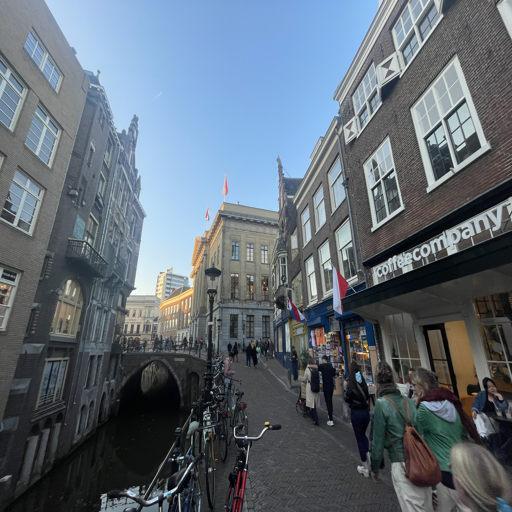
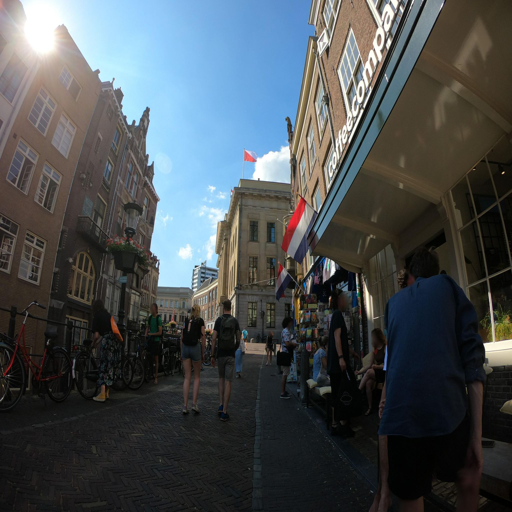

In [50]:
import folium
from folium.plugins import MarkerCluster
from PIL import Image
import base64
import pandas as pd
import io
from io import BytesIO
# Create a base map centered around the known image's location
m = folium.Map(location=[known_image_location[0], known_image_location[1]], zoom_start=15)

# Add marker for known image with custom icon (thumbnail image)
folium.Marker(
    location=[known_image_location[0], known_image_location[1]],
    popup=f"Known Image\nLat: {known_image_location[0]}, Lon: {known_image_location[1]}",
    tooltip="Known Image",
    icon=folium.CustomIcon(icon_image=known_image_path, icon_size=(50, 50))  # Resize the image as icon
).add_to(m)

# Add marker for unknown image with custom icon (thumbnail image)
folium.Marker(
    location=[new_lat, new_lon],
    popup=f"Unknown Image\nLat: {unknown_lat}, Lon: {unknown_long}",
    tooltip="Unknown Image",
    icon=folium.CustomIcon(icon_image=unknown_image_path, icon_size=(50, 50))  # Resize the image as icon
).add_to(m)

display(m)

In [15]:
# #ImgNorm = tvf.Compose([tvf.ToTensor(), tvf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# from PIL import Image, ImageFilter
# import numpy as np

# import kapture
# from kapture.io.csv import kapture_from_dir
# from kapture_localization.utils.pairsfile import get_ordered_pairs_from_file

# from dust3r_visloc.datasets.utils import cam_to_world_from_kapture, get_resize_function, rescale_points3d
# from dust3r_visloc.datasets.base_dataset import BaseVislocDataset
# from dust3r.datasets.utils.transforms import ImgNorm
# from dust3r.utils.geometry import xy_grid, geotrf



# class ImageView(): #tried to recreate from dust3r_visloc.datasets.inloc.py
#     def __init__(self,image_path, maxdim, patch_size):
#         self.image_path = image_path
#         #self.image = Image.open(image_path)
#         self.maxdim = maxdim 
#         self.patch_size = patch_size

#         # this is how patch size and maxdim are set usually 
#         # from dust3r_visloc.datasets.base_dataset
#         # self.maxdim = max(model.patch_embed.img_size)
#         # self.patch_size = model.patch_embed.patch_size

#     def get_view(self):
#         # Load RGB image
#         rgb_image = Image.open(self.image_path).convert('RGB')
#         rgb_image.load()
#         W, H = rgb_image.size
#         resize_func, to_resize, to_orig = get_resize_function(self.maxdim, self.patch_size, H, W)
#         rgb_tensor = resize_func(ImgNorm(rgb_image))
#         distortion = [0, 0, 0, 0]
#         f,cx,cy = 1,W/2,H/2 #dummy values for now
#         intrinsics = np.float32([(f, 0, cx),
#                                  (0, f, cy),
#                                  (0, 0, 1)])
#         cam_to_world = np.eye(4, dtype=np.float32)
#         view = {'intrinsics': intrinsics,
#                 'distortion': distortion,
#                 'cam_to_world': cam_to_world, #cam_to_world is shady right now
#                 'rgb': rgb_image,
#                 'rgb_rescaled': rgb_tensor,
#                 'to_orig': to_orig,
#                 'idx': None, #need to change
#                 'image_name': None #need to change
#             }
#         return view


# query_view = ImageView(my_image_path, maxdim=maxdim, patch_size=patch_size)
# map_view = ImageView(sequence_image_path, maxdim=maxdim, patch_size=patch_size)

{'intrinsics': array([[1.000e+00, 0.000e+00, 2.016e+03],
       [0.000e+00, 1.000e+00, 1.512e+03],
       [0.000e+00, 0.000e+00, 1.000e+00]], dtype=float32), 'distortion': [0, 0, 0, 0], 'cam_to_world': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32), 'rgb': <PIL.Image.Image image mode=RGB size=4032x3024 at 0x7F1F04C13210>, 'rgb_rescaled': tensor([[[ 0.0303,  0.0339,  0.0355,  ...,  0.2630,  0.2655,  0.2636],
         [-0.0022,  0.0272,  0.0147,  ...,  0.2601,  0.2653,  0.2658],
         [ 0.0113,  0.0345,  0.0516,  ...,  0.2811,  0.2637,  0.2522],
         ...,
         [-0.8271, -0.8209, -0.8410,  ..., -0.5133, -0.5170, -0.5375],
         [-0.8116, -0.8703, -0.8168,  ..., -0.4704, -0.5014, -0.5250],
         [-0.8235, -0.8537, -0.8470,  ..., -0.5215, -0.4876, -0.4844]],

        [[ 0.0852,  0.0888,  0.0904,  ...,  0.3406,  0.3435,  0.3368],
         [ 0.0527,  0.0821,  0.0696,  ...,  0.3376,  0.3408,  0.3370],
       

In [ ]:
CUDA_VISIBLE_DEVICES=4 python3 visloc.py --model_name MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric --dataset "VislocInLoc('/home/bjangley/VPR/mast3r/datasets/InLoc', pairsfile='pairs-query-netvlad40-temporal', topk=20)" --pixel_tol 5 --pnp_mode poselib --reprojection_error_diag_ratio 0.008 --output_dir /home/bjangley/VPR/mast3r/output --coarse_to_fine --max_image_size 1200 --max_batch_size 20 --c2f_crop_with_homography


In [2]:
import kapture
print(kapture_data.__version__)



NameError: name 'kapture_data' is not defined

In [ ]:
CUDA_VISIBLE_DEVICES=7 python3 visloc.py --model_name MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric --dataset "VislocAachenDayNight('/home/bjangley/VPR/mast3r/datasets/aachenv11/', subscene='${scene}', pairsfile='fire_top50', topk=20)" --pixel_tol 5 --pnp_mode poselib --reprojection_error_diag_ratio 0.008 --output_dir /home/bjangley/VPR/mast3r/datasets/aachenv11/output/${scene}/loc --coarse_to_fine --max_batch_size 48 --c2f_crop_with_homography

In [ ]:
VislocAachenDayNight('/home/bjangley/VPR/mast3r/datasets/aachenv11/', subscene='', pairsfile='fire_top50', topk=20): 1015 images - median_pos_error=np.float64(746.426988669509), median_angular_error=np.float64(172.46347360781476)  - acc@0.1m,1deg=0.000  - acc@0.25m,2deg=0.000  - acc@0.5m,5deg=0.000  - acc@5m,10deg=0.000